## Continuous case (Ambiguity Calculation)

For continuous case ambiguty calculation we are calculating the overlap region beteween the hypercube of feature space of different classes.

$\LARGE Formula:   mean(\frac{A_{inter1}}{A_{class1}}, \frac{A_{inter2}}{A_{class2}}....) $.

$A_{inter1}$ is the number of samples of class 1 in the common region and $A_{class1}$ is the number of total samples that belongs to class 1.


    feature1   feature2  class
0  35.740023  93.669750    0.0
1  49.013754  99.665744    0.0
2  34.017488  98.319512    0.0
3  34.061822  92.283300    0.0
4  39.225161  83.617416    0.0


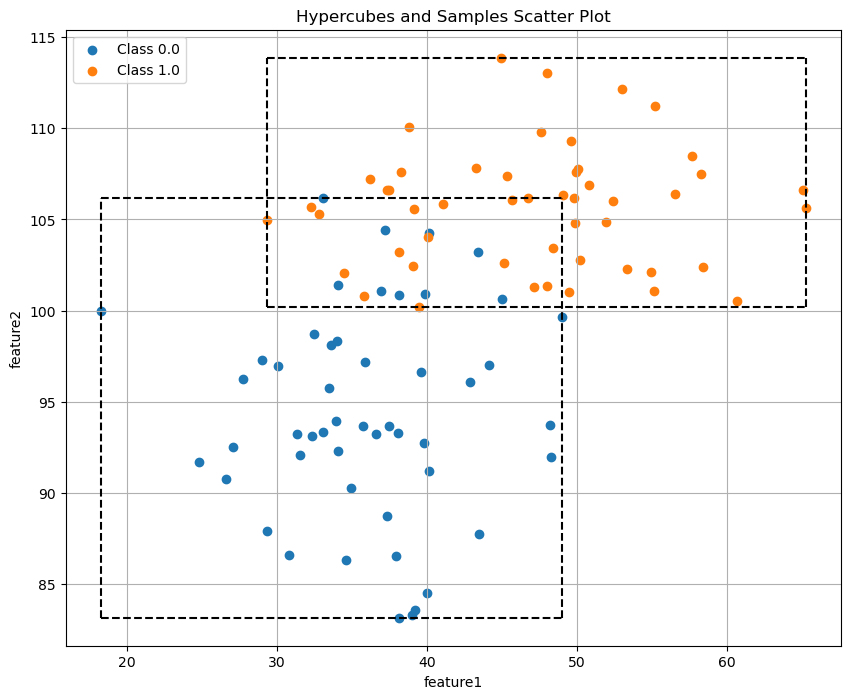

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Function to generate dataset
def create_synthetic_dataset(num_samples, num_classes, num_features=2, overlap=0.5, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)
    
    samples_per_class = num_samples // num_classes
    data = []
    class_labels = []
    
    # Initial means for the first class
    base_means = np.random.rand(num_features) * 100
    
    for cls in range(num_classes):
        # Adjust means for the current class to control overlap
        means = base_means + cls * (1 - overlap) * 20  # Adjusting overlap level
        std_devs = np.random.rand(num_features) * 10
        
        # Generate samples for this class
        class_data = np.random.randn(samples_per_class, num_features) * std_devs + means
        data.append(class_data)
        class_labels += [cls] * samples_per_class
    
    # Combine data from all classes
    data = np.vstack(data)
    class_labels = np.array(class_labels)
    
    # Create DataFrame
    columns = [f'feature{i+1}' for i in range(num_features)] + ['class']
    df = pd.DataFrame(np.column_stack((data, class_labels)), columns=columns)
    
    return df

# Functions to plot hypercube with scatter plots
def plot_hypercube_and_samples(df, feature_x, feature_y, class_column):
    classes = df[class_column].unique()
    plt.figure(figsize=(10, 8))
    
    for cls in classes:
        subset = df[df[class_column] == cls]
        min_x, max_x = subset[feature_x].min(), subset[feature_x].max()
        min_y, max_y = subset[feature_y].min(), subset[feature_y].max()
        
        # Plotting samples
        plt.scatter(subset[feature_x], subset[feature_y], label=f'Class {cls}')
        
        # Plotting hypercube boundaries
        plt.plot([min_x, max_x], [min_y, min_y], 'k--')
        plt.plot([min_x, max_x], [max_y, max_y], 'k--')
        plt.plot([min_x, min_x], [min_y, max_y], 'k--')
        plt.plot([max_x, max_x], [min_y, max_y], 'k--')
    
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title('Hypercubes and Samples Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()

synthetic_data = create_synthetic_dataset(num_samples=100, num_classes=2, num_features=2, random_state=42)
print(synthetic_data.head())

plot_hypercube_and_samples(synthetic_data, 'feature1', 'feature2', 'class')



In [35]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

def calculate_continuous_case_ambiguity(df, class_column):
    features = df.columns.drop(class_column)
    classes = df[class_column].unique()

    # Step 1: Calculate Hypercubes
    grouped = df.groupby(class_column)[features]
    min_values = grouped.min()
    max_values = grouped.max()
    hypercubes = {cls: (min_values.loc[cls].values, max_values.loc[cls].values) for cls in classes}

    # Step 2: Calculate Overlap Regions
    overlap_regions = []
    class_list = list(hypercubes.keys())
    num_classes = len(class_list)
    
    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            min_overlap = np.maximum(hypercubes[class_list[i]][0], hypercubes[class_list[j]][0])
            max_overlap = np.minimum(hypercubes[class_list[i]][1], hypercubes[class_list[j]][1])
            if np.all(min_overlap <= max_overlap):
                overlap_regions.append((class_list[i], class_list[j], min_overlap, max_overlap))

    # Step 3: Count Samples in Overlap Regions
    samples = df[features].values
    class_labels = df[class_column].values

    samples_in_overlap = {}

    for cls1, cls2, min_overlap, max_overlap in overlap_regions:
        in_overlap_cls1 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls1)
        in_overlap_cls2 = np.all((samples >= min_overlap) & (samples <= max_overlap), axis=1) & (class_labels == cls2)

        count_cls1 = np.sum(in_overlap_cls1)
        count_cls2 = np.sum(in_overlap_cls2)

        region_key = f'{cls1}-{cls2}'
        samples_in_overlap[region_key] = {cls1: count_cls1, cls2: count_cls2}

    # Step 4: Calculate Ambiguity
    total_samples_per_class = df[class_column].value_counts().to_dict()
    print("total samples per class:")
    print(total_samples_per_class)
    ambiguity_values = {cls: 0 for cls in classes}

    for region, counts in samples_in_overlap.items():
        cls1, cls2 = region.split('-')
        cls1 = float(cls1)  # Ensure class labels are correctly interpreted
        cls2 = float(cls2)
        if cls1 in total_samples_per_class and cls2 in total_samples_per_class:
            if total_samples_per_class[cls1] > 0:
                ambiguity_values[cls1] += counts[cls1] / total_samples_per_class[cls1]
            if total_samples_per_class[cls2] > 0:
                ambiguity_values[cls2] += counts[cls2] / total_samples_per_class[cls2]

    mean_ambiguity = np.mean(list(ambiguity_values.values())) if ambiguity_values else 0.0

    return mean_ambiguity, overlap_regions, samples_in_overlap


# Example usage
data3 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'feature2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

data2 = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
    'class': [1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3]
})

data = pd.DataFrame({
    'feature1': [1, 2, 3, 4, 5, 6],
    'feature2': [5, 6, 7, 8, 9, 10],
    'class': [0, 0, 1, 1, 0, 1]
})
ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_case_ambiguity(synthetic_data, 'class')

print(f'Continuous Case Ambiguity: {ambiguity}')
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")


total samples per class:
{0.0: 50, 1.0: 50}
Continuous Case Ambiguity: 0.25
Overlap regions between classes:
Classes 0.0 and 1.0: Min overlap [ 29.3617319 100.1754   ], Max overlap [ 49.01375402 106.16025114]
Samples in Overlap Regions:
Overlap region 0.0-1.0: {0.0: 9, 1.0: 16}


## Ambiguity calculation on real world datasets

<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shibl\AppData\Local\Temp\ipykernel_8452\4221448334.py:2: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\continuous\kidney-stone-dataset.csv")


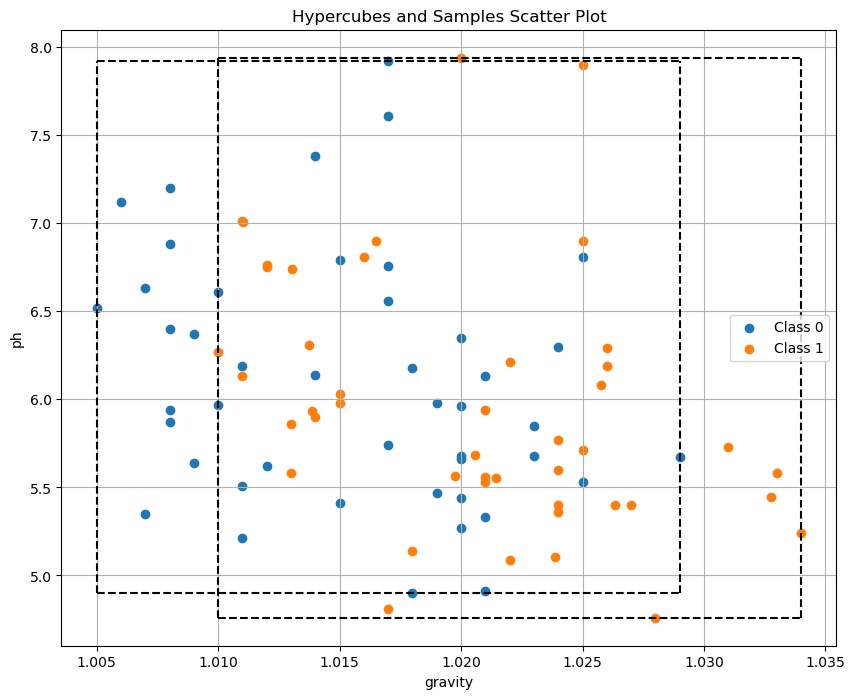

In [36]:
# kidney-stone dataset
df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\continuous\kidney-stone-dataset.csv")

plot_hypercube_and_samples(df, 'gravity', 'ph', 'target')

df_dropped = df.drop("Unnamed: 0", axis=1)

In [ ]:
df_dropped.head()

ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_case_ambiguity(df_dropped, 'target')

print(f'Continuous Case Ambiguity: {ambiguity}')
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")

total samples per class:
{0: 45, 1: 45}
Continuous Case Ambiguity: 0.6777777777777778
Overlap regions between classes:
Classes 0 and 1: Min overlap [  1.01   4.9  251.     5.1   64.     0.27], Max overlap [1.029e+00 7.920e+00 1.107e+03 3.360e+01 5.500e+02 8.480e+00]
Samples in Overlap Regions:
Overlap region 0-1: {0: 29, 1: 32}


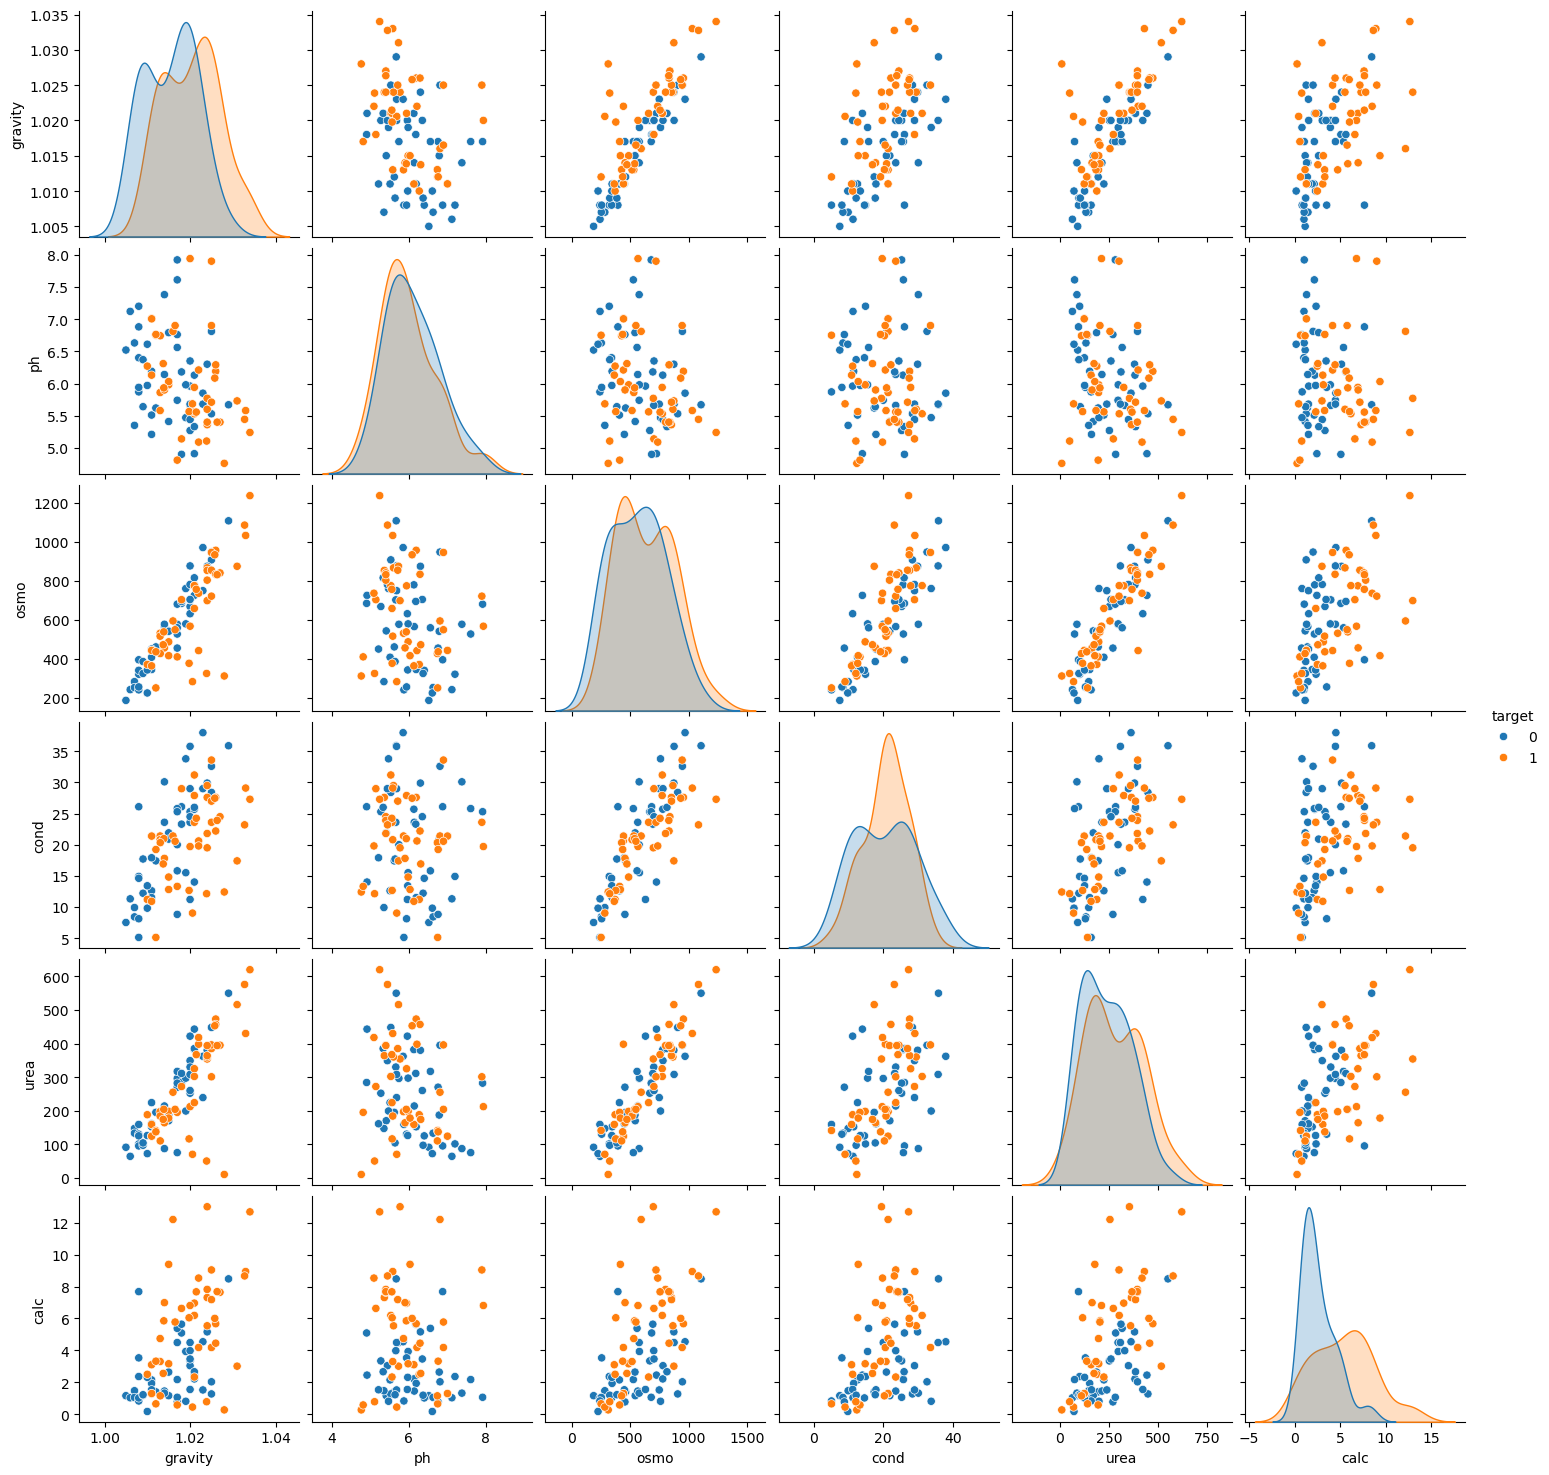

In [ ]:
import seaborn as sns
sns.pairplot(df_dropped, hue='target')

In [ ]:
# Implementaing classical machine learning algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score

def select_model(model):
    if model == "logistic_regression" :
        return LogisticRegression(max_iter=1000) 
    elif model == "naive_bayes":
        return GaussianNB()
    elif model == "random_forest":
        return RandomForestClassifier(max_depth=2, random_state=0)
    else:
        raise ValueError("Unknown model type: {}".format(model))
    


X = df_dropped.drop("target", axis=1)
y = df_dropped['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # global performance
    global_accuracy = accuracy_score(y_test, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")

Model name: logistic_regression, global_accuracy: 0.6666666666666666, Scores for each fold: [0.66666667 0.66666667 0.77777778 0.72222222 0.66666667], Average_score: 0.7
Model name: naive_bayes, global_accuracy: 0.6111111111111112, Scores for each fold: [0.61111111 0.77777778 0.77777778 0.61111111 0.55555556], Average_score: 0.6666666666666666
Model name: random_forest, global_accuracy: 0.6666666666666666, Scores for each fold: [0.66666667 0.83333333 0.83333333 0.77777778 0.66666667], Average_score: 0.7555555555555555


#### ambiguity estimation Iris dataset (3 class)

In [38]:
# Ambiguity calculation on Iris dataset
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder

# Load the Iris dataset
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['class'] = iris.target_names[iris.target]

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Transform the class labels from string to numeric values
iris_df['class'] = label_encoder.fit_transform(iris_df['class'])

# ambiguity calculation on iris dataset
ambiguity, overlap_regions, samples_in_overlap = calculate_continuous_case_ambiguity(iris_df, 'class')

print(f'Continuous Case Ambiguity: {ambiguity}')
print("Overlap regions between classes:")
for cls1, cls2, min_overlap, max_overlap in overlap_regions:
    print(f"Classes {cls1} and {cls2}: Min overlap {min_overlap}, Max overlap {max_overlap}")

print("Samples in Overlap Regions:")
for region, counts in samples_in_overlap.items():
    print(f"Overlap region {region}: {counts}")

iris_df.columns.to_list()

total samples per class:
{0: 50, 1: 50, 2: 50}
Continuous Case Ambiguity: 0.17333333333333334
Overlap regions between classes:
Classes 1 and 2: Min overlap [4.9 2.2 4.5 1.4], Max overlap [7.  3.4 5.1 1.8]
Samples in Overlap Regions:
Overlap region 1-2: {1: 18, 2: 8}


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)',
 'class']

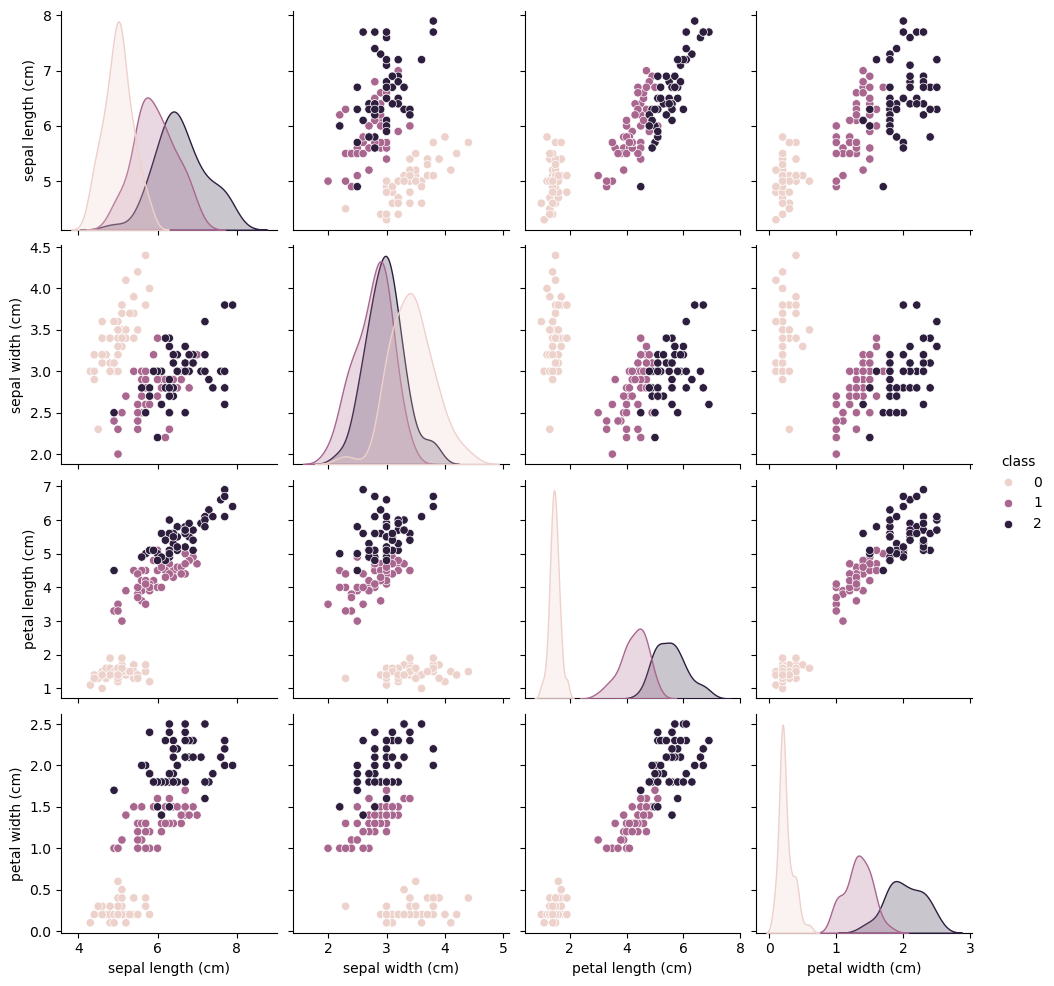

In [ ]:
import seaborn as sns
sns.pairplot(iris_df, hue='class')

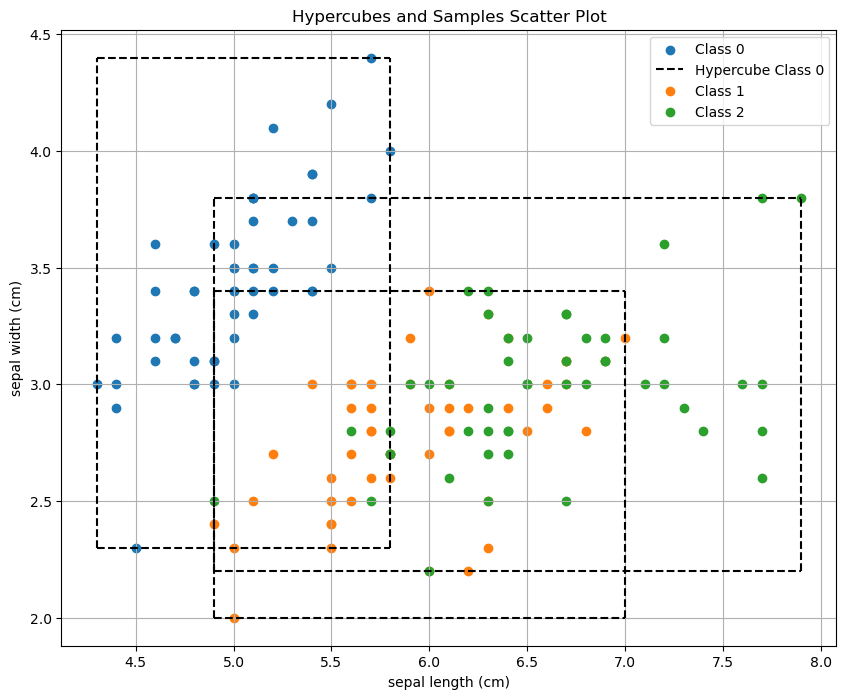

In [ ]:
plot_hypercube_and_samples(iris_df, 'sepal length (cm)', 'sepal width (cm)', 'class')

In [33]:
# classical model implementation
X = iris_df.drop("class", axis=1)
y = iris_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model_names = ["logistic_regression", "naive_bayes", "random_forest"]

for model_name in model_names:
    model = select_model(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # global performance
    global_accuracy = accuracy_score(y_test, y_pred)
    # Cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=kf)
    print(f"Model name: {model_name}, global_accuracy: {global_accuracy}, Scores for each fold: {scores}, Average_score: {np.mean(scores)}")

NameError: name 'train_test_split' is not defined

## Continuous case (Error calculation):


$\LARGE Formula: \int_{R_1} P(C_2) + \int_{R_2} P(C_1)$


In [18]:
# Error calculation on kidney-stone dataset
from sklearn.tree import DecisionTreeClassifier, export_text, _tree
from scipy import stats

def calculate_error_probability(df, label_column):
    # Train the decision tree
    feature_columns = [col for col in df.columns if col != label_column]
    X = df[feature_columns]
    y = df[label_column]

    clf = DecisionTreeClassifier(max_depth=None)
    clf.fit(X, y)

    training_accuracy = clf.score(X, y)
    print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

    # Function to extract rectangles and labels from a trained decision tree
    def get_rectangles_from_tree(tree):
        left = tree.children_left
        right = tree.children_right
        threshold = tree.threshold
        feature = tree.feature
        value = tree.value
        
        def recurse(node, bounds):
            if feature[node] == _tree.TREE_UNDEFINED:
                # It's a leaf node
                leaf_label = np.argmax(value[node][0])
                return [(bounds, leaf_label)]
            
            new_bounds_left = [list(b) for b in bounds]
            new_bounds_right = [list(b) for b in bounds]
            
            feature_index = feature[node]
            threshold_value = threshold[node]
            
            new_bounds_left[feature_index][1] = threshold_value
            new_bounds_right[feature_index][0] = threshold_value
            
            left_rectangles = recurse(left[node], new_bounds_left)
            right_rectangles = recurse(right[node], new_bounds_right)
            
            return left_rectangles + right_rectangles

        # Initialize bounds for each feature
        initial_bounds = [[-np.inf, np.inf] for _ in range(tree.n_features)]
        rectangles = recurse(0, initial_bounds)
        return rectangles

    # Extract rectangles and labels from the decision tree
    rectangles = get_rectangles_from_tree(clf.tree_)
    print(rectangles)
    # Calculate KDE for each class
    classes = np.unique(df[label_column])
    kde_by_class = {}
    for cls in classes:
        class_data = df[df[label_column] == cls][feature_columns]
        kde_by_class[cls] = stats.gaussian_kde(class_data.T)

    # Calculate probabilities for the segments
    segment_probabilities = []
    for rect, predicted_label in rectangles:
        bounds_min = [b[0] for b in rect]
        bounds_max = [b[1] for b in rect]
        segment = df[np.all((df[feature_columns] >= bounds_min) & (df[feature_columns] < bounds_max), axis=1)]

        if not segment.empty:
            # Calculate the probability of misclassification for this segment
            error_probability = 0
            for cls in classes:
                if cls != predicted_label:
                    kde = kde_by_class[cls]
                    error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)
            
            segment_probabilities.append(error_probability)


    # Compute total error probability
    total_error_probability_all_segments = np.sum(segment_probabilities)
    
    return total_error_probability_all_segments

df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\continuous\kidney-stone-dataset.csv")
df_dropped = df.drop("Unnamed: 0", axis=1)

feature_columns = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
label_column = 'target'
total_error_probability = calculate_error_probability(df_dropped, label_column)

print(f"Total error probability across all segments: {total_error_probability:.4f}")
print(f"Accuracy: {1 - total_error_probability:.4f}")


<>:83: SyntaxWarning: invalid escape sequence '\F'
<>:83: SyntaxWarning: invalid escape sequence '\F'
C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:83: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("D:\FAU_Courses\FAU Summer 2024\Seminar\Codes\data\continuous\kidney-stone-dataset.csv")


Training Accuracy: 100.00%
[([[-inf, 1.0110073685646057], [-inf, inf], [-inf, 354.5], [-inf, inf], [-inf, inf], [-inf, 5.6549999713897705]], 0), ([[-inf, 1.0110073685646057], [-inf, 5.884999990463257], [354.5, 536.0], [-inf, inf], [-inf, inf], [-inf, 5.6549999713897705]], 0), ([[-inf, 1.0110073685646057], [5.884999990463257, inf], [354.5, 536.0], [-inf, inf], [-inf, inf], [-inf, 5.6549999713897705]], 1), ([[1.0110073685646057, inf], [-inf, inf], [-inf, 449.0], [-inf, inf], [-inf, inf], [-inf, 5.6549999713897705]], 1), ([[1.0110073685646057, inf], [-inf, inf], [449.0, 536.0], [-inf, inf], [-inf, inf], [-inf, 2.3632025718688965]], 0), ([[1.0110073685646057, inf], [-inf, inf], [449.0, 536.0], [-inf, inf], [-inf, inf], [2.3632025718688965, 5.6549999713897705]], 1), ([[-inf, 1.0200000405311584], [-inf, inf], [536.0, inf], [-inf, inf], [-inf, 231.5], [-inf, 5.6549999713897705]], 0), ([[1.0200000405311584, 1.0235000252723694], [-inf, inf], [536.0, inf], [-inf, inf], [-inf, 231.5], [-inf, 5.65

C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:73: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)
C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:73: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)
C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:73: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)


Total error probability across all segments: 0.5772
Accuracy: 0.4228


C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:73: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)
C:\Users\shibl\AppData\Local\Temp\ipykernel_19540\3586253875.py:73: UserWarning: An integral in _mvn.mvnun requires more points than 6000
  error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=200000)


In [39]:
# Error calculation on iris datasets
label_column = 'class'
total_error_probability = calculate_error_probability(iris_df, label_column)

print(f"Total error probability across all segments: {total_error_probability:.4f}")
print(f"Accuracy: {1 - total_error_probability:.4f}")

Training Accuracy: 100.00%
Total error probability across all segments: 0.1763
Accuracy: 0.8237


# Discrete case (Ambiguity calculation):
$\LARGE Formula: \frac{d} {d-1} \sum_N 1 - max(\frac{|i_j|} {|i|}) \frac{1}{N} $

where d = no of class, N = Permutation of Features of data D

In [1]:
import pandas as pd

data = {
    "x1": [0, 0, 1, 1, 0, 0, 1],
    "x2": [0, 1, 0, 1, 0, 0, 0],
    "L": [0, 1, 1, 0, 1, 0, 0]
}
df1 = pd.DataFrame(data)


def calculate_discrete_ambiguity(df, feature_columns, class_column):
    
    d = df[class_column].nunique()
    # combinaion generators
    df["feature_combination"] = df[feature_columns].astype(str).agg('_'.join, axis=1)
    
    # total no of combinations
    combination_counts = df.groupby(['feature_combination', class_column]).size().reset_index(name='count')
    
    # no of combination
    total_combination_counts = df['feature_combination'].value_counts().reset_index(name='total_count').rename(columns={'index': 'feature_combination'})
    
    combination_probs = pd.merge(combination_counts, total_combination_counts, on='feature_combination')
    combination_probs['probability'] = combination_probs['count'] / combination_probs['total_count']
    
    
    combination_probs_pivot = combination_probs.pivot(index='feature_combination', columns=class_column, values='probability').fillna(0)
    combination_probs_pivot.columns = [f'P(class={int(col)})' for col in combination_probs_pivot.columns]
    
    df = pd.merge(df, combination_probs, on=['feature_combination', class_column], how='left')

    ambiguity = ((1-combination_probs_pivot.max(axis=1))*(d/(d-1))).mean() # 
    
    return ambiguity, df, combination_probs_pivot




ambiguity, df, combination_pivot = calculate_discrete_ambiguity(df1, feature_columns=["x1", "x2"], class_column="L")

print("Discrete case ambiguity: ", ambiguity)


combination_pivot

Discrete case ambiguity:  0.4166666666666667


,P(class=0),P(class=1)
feature_combination,,
0_0,0.666667,0.333333
0_1,0.000000,1.000000
1_0,0.500000,0.500000
1_1,1.000000,0.000000


In [29]:
# test for categorical cases
def generate_dummy_categorical_classification_dataset(num_rows=100):
    # Define categories
    np.random.seed(42)
    genders = ['Male', 'Female', 'Other']
    marital_statuses = ['Single', 'Married', 'Divorced', 'Widowed']
    blood_types = ['A', 'B', 'AB', 'O']
    
    # Generate random data
    data = {
        'Gender': np.random.choice(genders, num_rows),
        'Marital Status': np.random.choice(marital_statuses, num_rows),
        'Blood Type': np.random.choice(blood_types, num_rows),
        'Label': np.random.choice([0, 1], num_rows)
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df

df3 = generate_dummy_categorical_classification_dataset(100)

group_columns = df3.columns.to_list()[:-1]
label_column = 'Label'
ambiguity, df, combination_pivot = calculate_discrete_ambiguity(df3, feature_columns=group_columns, class_column=label_column)

print("Discrete case ambiguity: ", ambiguity)


Discrete case ambiguity:  0.4439393939393939


### Discrete case ambiguity on real world dataset


In [1]:
# Discrete case ambiguity estimation on Social network ads datasets
network_df = pd.read_csv('D:/FAU_Courses/FAU Summer 2024/Seminar/Codes/data/Social_Network_Ads.csv')

ambiguity, df, combination_pivot = calculate_discrete_ambiguity(network_df, feature_columns=["Age", "EstimatedSalary"], class_column="Purchased")

print("Discrete case ambiguity: ", ambiguity)



NameError: name 'pd' is not defined

In [31]:
milk_df.columns.to_list()

NameError: name 'milk_df' is not defined

In [ ]:

milk_df = pd.read_csv('D:/FAU_Courses/FAU Summer 2024/Seminar/Codes/data/milknew.csv')
label_encoder = LabelEncoder()

# Transform the class labels from string to numeric values
milk_df['Grade'] = label_encoder.fit_transform(milk_df['Grade'])

ambiguity, df, combination_pivot = calculate_discrete_ambiguity(milk_df, feature_columns=['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour'], class_column="Grade")

print("Discrete case ambiguity: ", ambiguity)
combination_pivot['P(class=0)'].unique()

Discrete case ambiguity:  0.0


array([0., 1.])

# Discrete case (Error calculation):
$\LARGE Error: \frac{1}{N} \sum_{i\in N } \frac{|i| -max(i_k)}{|i|} $ 

In [16]:
import pandas as pd

# Your data
data = pd.DataFrame({
    'f1':    [1, 1, 2, 2, 1, 2, 1, 2, 2],
    'f2':    [1, 2, 1, 2, 1, 2, 2, 1, 1],
    'class': [0, 0, 1, 1, 0, 1, 0, 0, 0]
})


feature_combinations = data.groupby(['f1', 'f2', 'class']).size().reset_index(name='count')

pivot_table = feature_combinations.pivot_table(index=['f1', 'f2'], columns='class', values='count', fill_value=0)

pivot_table['total_count'] = pivot_table.sum(axis=1)

pivot_table['max_count'] = pivot_table[[0, 1]].max(axis=1)

pivot_table['error'] = (pivot_table['total_count'] - pivot_table['max_count']) / pivot_table['total_count']

mean_error = pivot_table['error'].mean()

print("Mean Error:", mean_error)

pivot_table

Mean Error: 0.08333333333333333


class    0    1  total_count  max_count     error
f1 f2                                            
1  1   2.0  0.0          2.0        2.0  0.000000
   2   2.0  0.0          2.0        2.0  0.000000
2  1   2.0  1.0          3.0        2.0  0.333333
   2   0.0  2.0          2.0        2.0  0.000000

In [2]:
import pandas as pd

data = pd.DataFrame({
    'f1':    [1, 1, 2, 2, 1, 2, 1, 2, 2],
    'f2':    [1, 2, 1, 2, 1, 2, 2, 1, 1],
    'class': [0, 0, 1, 1, 0, 1, 2, 0, 0]
})

feature_columns = [col for col in data.columns if col != 'class']
feature_combinations = data.groupby(feature_columns + ['class']).size().reset_index(name='count')
pivot_table = feature_combinations.pivot_table(index=feature_columns, columns='class', values='count', fill_value=0)
pivot_table['total_count'] = pivot_table.sum(axis=1)
class_columns = pivot_table.columns[pivot_table.columns != 'total_count']
pivot_table['max_count'] = pivot_table[class_columns].max(axis=1)
pivot_table['error'] = (pivot_table['total_count'] - pivot_table['max_count']) / pivot_table['total_count']
mean_error = pivot_table['error'].mean()

print("Mean Error:", mean_error)
pivot_table



Mean Error: 0.20833333333333331


class    0    1    2  total_count  max_count     error
f1 f2                                                 
1  1   2.0  0.0  0.0          2.0        2.0  0.000000
   2   1.0  0.0  1.0          2.0        1.0  0.500000
2  1   2.0  1.0  0.0          3.0        2.0  0.333333
   2   0.0  2.0  0.0          2.0        2.0  0.000000

In [4]:
import pandas as pd

def calculate_mean_error(data, class_column):
    
    feature_columns = [col for col in data.columns if col != class_column]
    feature_combinations = data.groupby(feature_columns + [class_column]).size().reset_index(name='count')

    pivot_table = feature_combinations.pivot_table(index=feature_columns, columns=class_column, values='count', fill_value=0)

    pivot_table['total_count'] = pivot_table.sum(axis=1)
    class_columns = pivot_table.columns[pivot_table.columns != 'total_count']

    pivot_table['max_count'] = pivot_table[class_columns].max(axis=1)

    pivot_table['error'] = (pivot_table['total_count'] - pivot_table['max_count']) / pivot_table['total_count']

    mean_error = pivot_table['error'].mean()

    return mean_error, pivot_table

# Example usage
data = pd.DataFrame({
    'f1':    [1, 1, 2, 2, 1, 2, 1, 2, 2],
    'f2':    [1, 2, 1, 2, 1, 2, 2, 1, 1],
    'class': [0, 0, 1, 1, 0, 1, 0, 0, 0]
})

mean_error, pivot_table = calculate_mean_error(data, "class")
print("Mean Error:", mean_error)


Mean Error: 0.08333333333333333


In [6]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
zoo = fetch_ucirepo(id=111) 
  
# data (as pandas dataframes) 
X = zoo.data.features 
y = zoo.data.targets 
zoo_df = pd.concat([X, y], axis=1)

mean_error, pivot_table = calculate_mean_error(zoo_df, "type")
print("Mean Error:", mean_error)
pivot_table

Mean Error: 0.0


type                                                                                                                     1  \
hair feathers eggs milk airborne aquatic predator toothed backbone breathes venomous fins legs tail domestic catsize         
0    0        0    0    0        0       1        0       0        1        1        0    8    1    0        0         0.0   
                                 1       1        1       1        0        1        0    0    1    0        0         0.0   
                   1    0        1       1        1       1        1        0        1    0    1    0        1         2.0   
              1    0    0        0       0        0       0        1        0        0    0    0    0        0         0.0   
                                                                                          6    0    0        0         0.0   
                                                          1        1        0        0    4    1    0        1         0.0   
                                         1        0       0        0        0        0    0    0    0        0         0.0   
                                                  1       1        1        0        0    0    1    0        0         0.0   
                                                                                          4    1    0        0         0.0   
                                                                            1        0    0    1    0        0         0.0   
                                 1       0        1       1        0        0        1    0    1    0        0         0.0   
                                                                                                    1        0         0.0   
                                                                   1        0        0    4    0    0        0         0.0   
                                         1        0       0        0        0        0    4    0    0        0         0.0   
                                                                                          5    0    0        0         0.0   
                                                                                          6    0    0        0         0.0   
                                                                                          8    0    0        1         0.0   
                                                                            1        0    0    0    0        0         0.0   
                                                  1       1        0        0        1    0    1    0        0         0.0   
                                                                                                             1         0.0   
                                                                            1        1    0    1    0        1         0.0   
                                                                   1        0        0    4    0    0        0         0.0   
                                                                                               1    0        0         0.0   
                                                                            1        0    4    0    0        0         0.0   
                        1        0       0        0       0        1        0        0    6    0    0        0         0.0   
                                         1        0       0        1        0        0    6    0    0        0         0.0   
     1        1    0    0        0       0        0       1        1        0        0    2    1    0        1         0.0   
                                         1        0       1        1        0        0    2    1    0        0         0.0   
                                                                                                             1         0.0   
                                 1       1        0       1        1        0        0    2   

# Categorical dataset

In [ ]:
import pandas as pd
import numpy as np

def generate_dummy_categorical_classification_dataset(num_rows=100):
    # Define categories
    np.random.seed(42)
    genders = ['Male', 'Female', 'Other']
    marital_statuses = ['Single', 'Married', 'Divorced', 'Widowed']
    blood_types = ['A', 'B', 'AB', 'O']
    
    # Generate random data
    data = {
        'Gender': np.random.choice(genders, num_rows),
        'Marital Status': np.random.choice(marital_statuses, num_rows),
        'Blood Type': np.random.choice(blood_types, num_rows),
        'Label': np.random.choice([0, 1], num_rows)
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    return df

# Example usage


def calculate_discrete_case_ambiguity(df, group_columns, label_column):
    # Group by the specified columns including the label column
    grouped = df.groupby(group_columns + [label_column]).size().unstack(label_column)
    
    # Normalize counts
    normalized_counts = (grouped / grouped.sum(axis=1).values.reshape(-1, 1)).fillna(0)
    
    # Calculate minimum proportion and scale
    min_proportions = normalized_counts.min(axis=1)
    scaled_min_proportions = min_proportions / 0.5
    
    # Return the mean of scaled minimum proportions
    return scaled_min_proportions.mean()

dummy_df = generate_dummy_categorical_classification_dataset(100)
# Get all columns except the label column
group_columns = dummy_df.columns.to_list()[:-1]
label_column = 'Label'

ambiguity = calculate_discrete_case_ambiguity(dummy_df, group_columns, label_column)
print(ambiguity)

0.4439393939393939


## Error calculation for mixed datasets

In [ ]:
# error calculation for mixed datasets with continuous and categorical features

def calculate_continuous_error(df, label_column):
    # Train the decision tree
    feature_columns = [col for col in df.columns if col != label_column]
    X = df[feature_columns]
    y = df[label_column]

    clf = DecisionTreeClassifier(max_depth=None)
    clf.fit(X, y)

    training_accuracy = clf.score(X, y)
    print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

    # Function to extract rectangles and labels from a trained decision tree
    def get_rectangles_from_tree(tree):
        left = tree.children_left
        right = tree.children_right
        threshold = tree.threshold
        feature = tree.feature
        value = tree.value
        
        def recurse(node, bounds):
            if feature[node] == _tree.TREE_UNDEFINED:
                # It's a leaf node
                leaf_label = np.argmax(value[node][0])
                return [(bounds, leaf_label)]
            
            new_bounds_left = [list(b) for b in bounds]
            new_bounds_right = [list(b) for b in bounds]
            
            feature_index = feature[node]
            threshold_value = threshold[node]
            
            new_bounds_left[feature_index][1] = threshold_value
            new_bounds_right[feature_index][0] = threshold_value
            
            left_rectangles = recurse(left[node], new_bounds_left)
            right_rectangles = recurse(right[node], new_bounds_right)
            
            return left_rectangles + right_rectangles

        # Initialize bounds for each feature
        initial_bounds = [[-np.inf, np.inf] for _ in range(tree.n_features)]
        rectangles = recurse(0, initial_bounds)
        return rectangles

    # Extract rectangles and labels from the decision tree
    rectangles = get_rectangles_from_tree(clf.tree_)
    print("rectangles: {rectangles}")
    
    # Calculate KDE for each class
    classes = np.unique(df[label_column])
    kde_by_class = {}
    for cls in classes:
        class_data = df[df[label_column] == cls][feature_columns]
        kde_by_class[cls] = stats.gaussian_kde(class_data.T)

    # Calculate probabilities for the segments
    segment_probabilities = []
    for rect, predicted_label in rectangles:
        bounds_min = [b[0] for b in rect]
        bounds_max = [b[1] for b in rect]
        segment = df[np.all((df[feature_columns] >= bounds_min) & (df[feature_columns] < bounds_max), axis=1)]

        if not segment.empty:
            # Calculate the probability of misclassification for this segment
            error_probability = 0
            for cls in classes:
                if cls != predicted_label:
                    kde = kde_by_class[cls]
                    error_probability += kde.integrate_box(bounds_min, bounds_max, maxpts=500000)
            
            segment_probabilities.append(error_probability)


    # Compute total error probability
    total_error_probability_all_segments = np.sum(segment_probabilities)
    return total_error_probability_all_segments



Training Accuracy: 100.00%


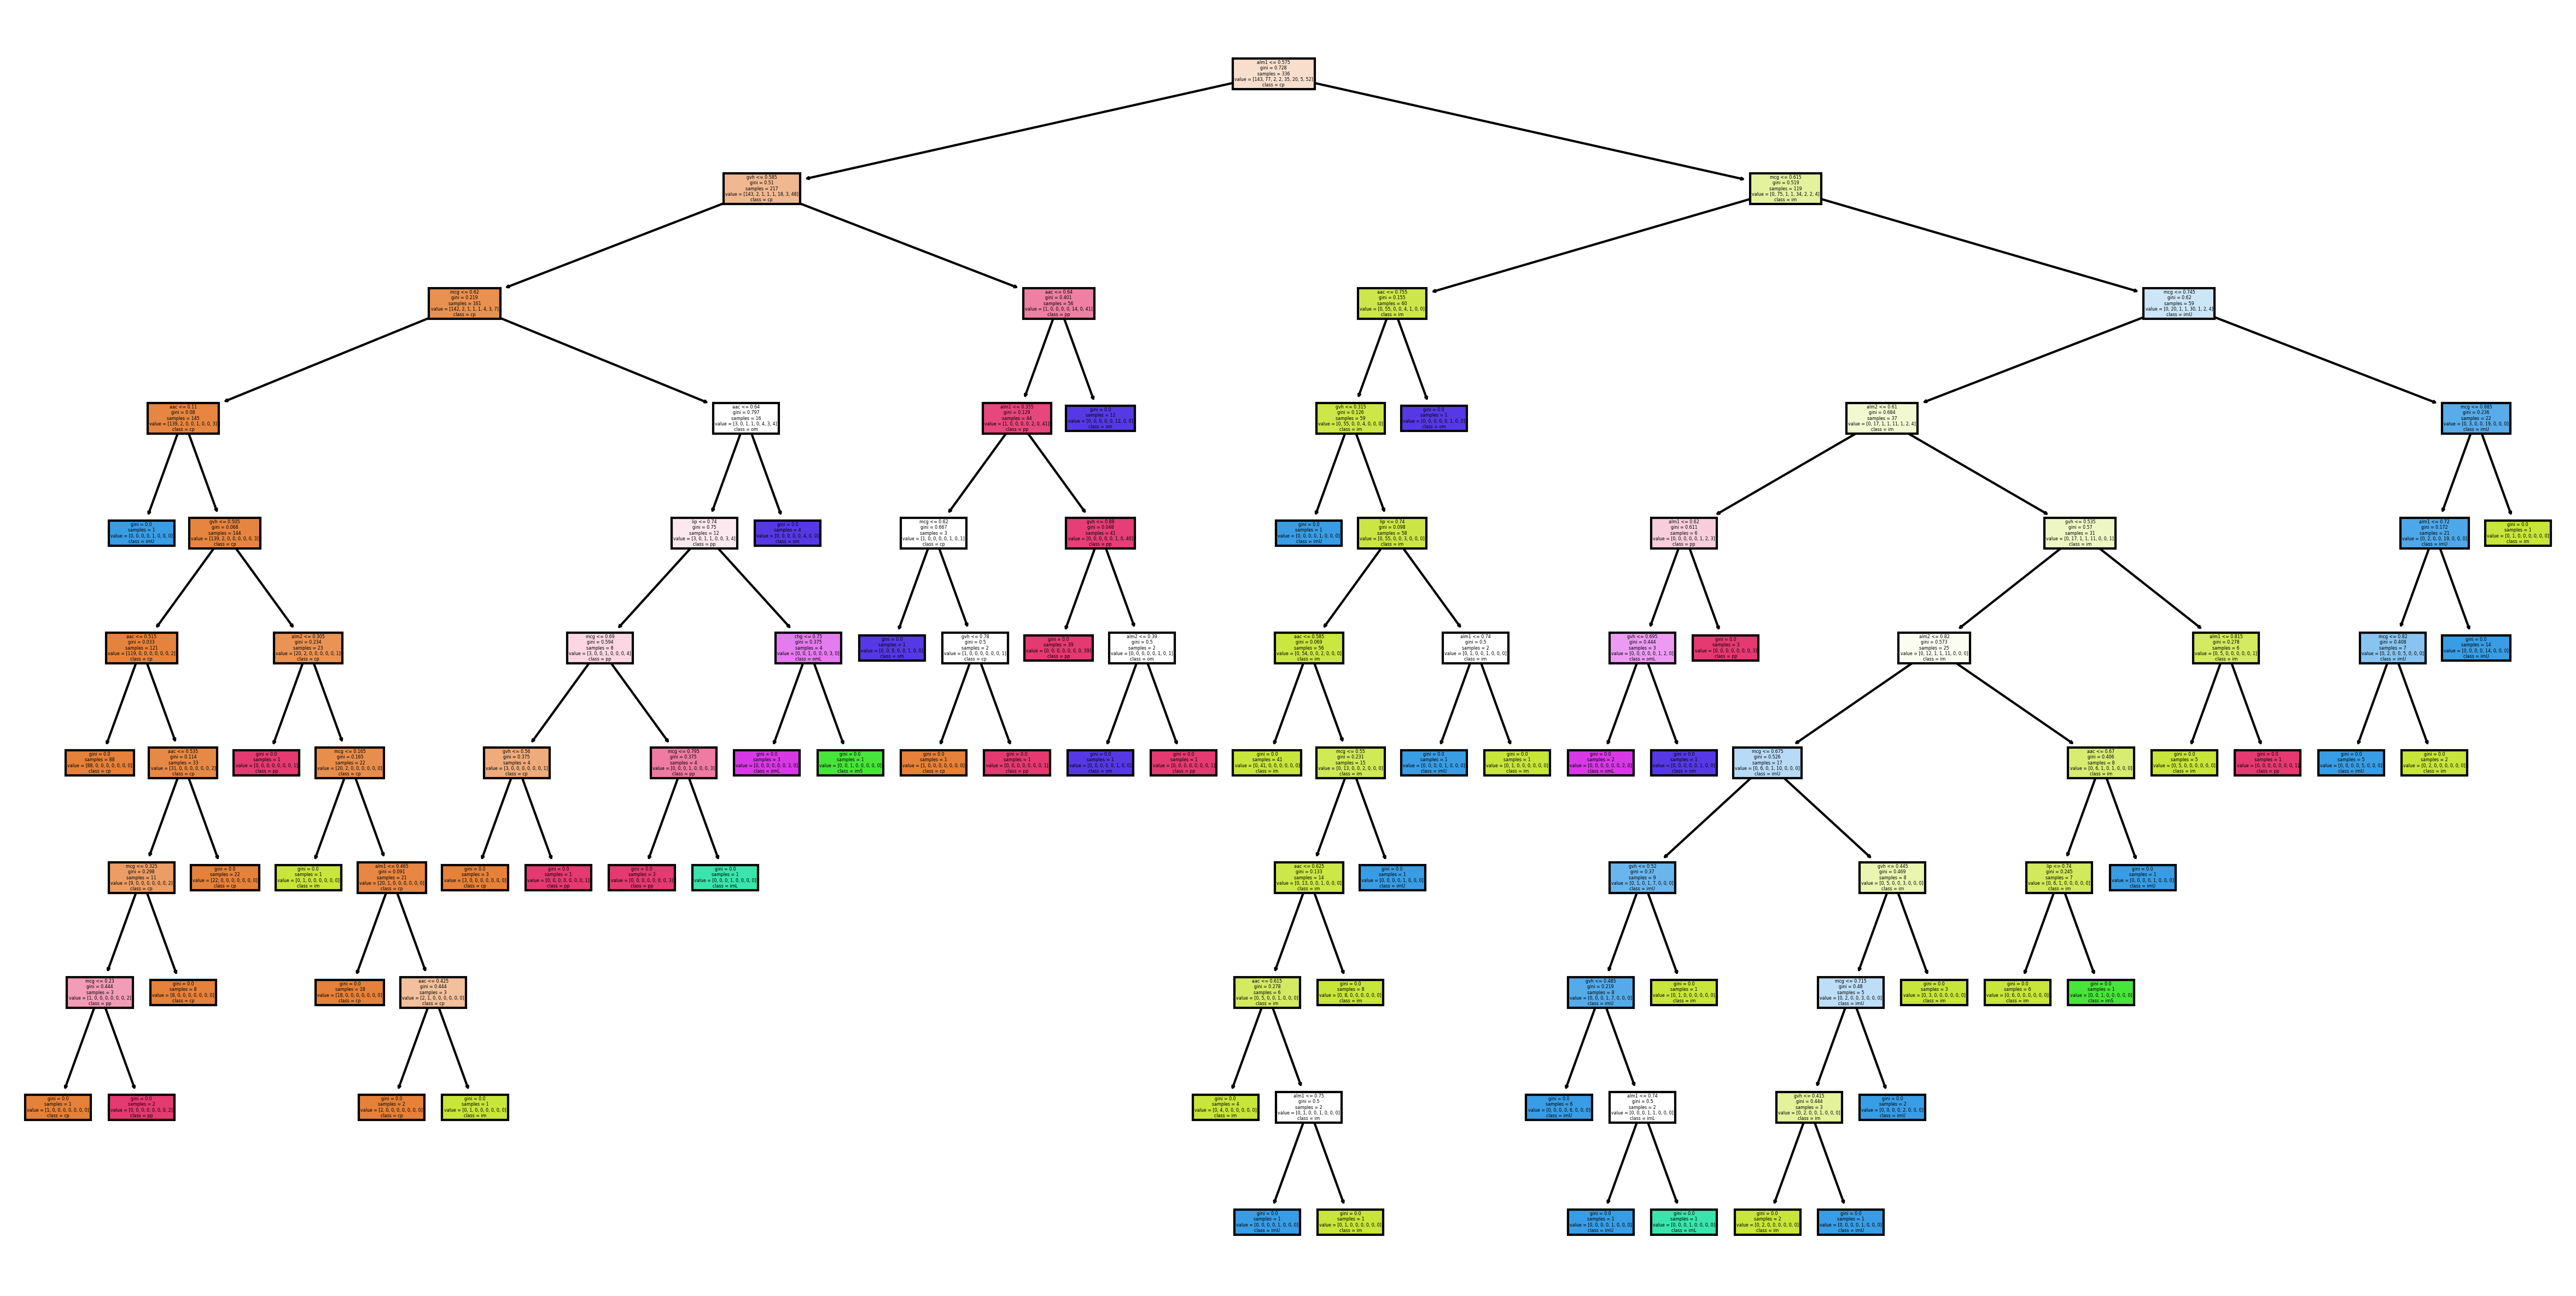

In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Fetch dataset
ecoli = fetch_ucirepo(id=39)

# Data (as pandas dataframes)
X = ecoli.data.features
y = pd.Series(ecoli.data.targets.values.flatten())  # Convert y to a pandas Series

# Combine features and target into a single DataFrame (optional, just for inspection)
ecoli_df = pd.concat([X, y], axis=1)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1)
clf.fit(X, y)

# Calculate and print training accuracy
training_accuracy = clf.score(X, y)
print(f'Training Accuracy: {training_accuracy * 100:.2f}%')

# Ensure class names are strings
class_names = [str(name) for name in y.unique()]

# Convert feature names to a list
feature_names = list(X.columns)

# Plot the decision tree with increased resolution
plt.figure(figsize=(20, 10), dpi=300)  # Increase the figure size and resolution
plot_tree(clf, filled=True, feature_names=feature_names, class_names=class_names)
plt.show()




In [4]:
ecoli_df

,mcg,gvh,lip,chg,aac,alm1,alm2,0
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...
331,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
332,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
333,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
334,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [11]:
ecoli_df['alm2'].unique()

array([0.35, 0.44, 0.46, 0.36, 0.34, 0.39, 0.57, 0.3 , 0.37, 0.29, 0.28,
       0.52, 0.58, 0.38, 0.32, 0.  , 0.14, 0.43, 0.23, 0.42, 0.41, 0.31,
       0.4 , 0.49, 0.47, 0.5 , 0.61, 0.27, 0.17, 0.59, 0.26, 0.45, 0.54,
       0.48, 0.2 , 0.51, 0.53, 0.56, 0.25, 0.33, 0.55, 0.84, 0.89, 0.8 ,
       0.78, 0.87, 0.79, 0.73, 0.69, 0.63, 0.92, 0.74, 0.88, 0.7 , 0.75,
       0.83, 0.86, 0.81, 0.85, 0.77, 0.66, 0.71, 0.9 , 0.76, 0.82, 0.67,
       0.72, 0.68, 0.94, 0.21, 0.99, 0.62, 0.15, 0.01, 0.16, 0.19, 0.24])